In [1]:
import datetime
import shutil
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torch.nn import functional as F
from tqdm import tqdm
import os
from torch.utils.data import ConcatDataset
from einops import rearrange, repeat
from einops.layers.torch import Rearrange
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
import torchvision.utils as vutils

torch.manual_seed(1337)

LEARNING_RATE = 3e-5

BATCH_SIZE = 8

IMAGE_SIZE = 64
BLOCK_SIZE = IMAGE_SIZE * IMAGE_SIZE - 1

CHANNELS_IMG = 3

N_EMBD = 128
N_HEAD = 6
N_LAYER = 6
DROPOUT = 0.2

VERSION = "5.0.0.2_bigData"

#----------------------------------------------

def create_spiral(n):
    # Initialize a n x n matrix
    matrix = [[0] * n for _ in range(n)]

    x, y = 0, 0

    # Direction vectors (right, down, left, up)
    dx = [0, 1, 0, -1]
    dy = [1, 0, -1, 0]
    direction = 0

    for i in range(n * n - 1, -1, -1):  # Start from n*n - 1 (35 for 6x6) and go down to 0
        matrix[x][y] = i

        nx = x + dx[direction]
        ny = y + dy[direction]

        # Change direction if next position is out of bounds or already filled
        if nx < 0 or nx >= n or ny < 0 or ny >= n or matrix[nx][ny] != 0:
            direction = (direction + 1) % 4  # Change direction
            nx = x + dx[direction]
            ny = y + dy[direction]

        x, y = nx, ny

    return matrix

spiral_indices = torch.tensor(create_spiral(IMAGE_SIZE))


def convertBackToImg(idx):
    positions_in_spiral = torch.argsort(spiral_indices.flatten())
    reconstructed_tensor = torch.zeros((3,IMAGE_SIZE*IMAGE_SIZE), device=device)
    idx = torch.cat((idx, torch.zeros((1,3), device=device)), dim=0)
    reconstructed_tensor[:,positions_in_spiral] = rearrange(idx, 'h c -> c h')
    reconstructed_tensor = reconstructed_tensor.view(3,IMAGE_SIZE, IMAGE_SIZE)
    return rearrange(reconstructed_tensor, 'c h w -> 1 c h w')

@torch.no_grad()
def get_batch(data, spiral = spiral_indices):
    B, C ,H ,W = data.shape

    spiral_data = torch.zeros_like(data.view(B, C, -1)).to(device)

    spiral_data[:,:,spiral.flatten()] = data.view(B, C, -1)

    x = spiral_data[:, :, :BLOCK_SIZE]
    y = spiral_data[:, :, 1:BLOCK_SIZE+1]

    x, y = x.to(device), y.to(device)
    x = rearrange(x, 'b c h -> b h c')
    y = rearrange(y, 'b c h -> b h c')
    return x, y

@torch.no_grad()
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def model_saveFile(version):
    return f"tempModel/model{VERSION}_FloorEP{version}.pth"

@torch.no_grad()
def validate(model, dataloader):
    total_loss = 0
    total_samples = 0
    for idx, (data, _) in enumerate(dataloader):
        dataRaw = data.squeeze(0).to(device)
        x, y = get_batch(dataRaw)
        
        _, loss = model(x, y)

        total_loss += loss.item()
        total_samples += 1
    return total_loss / total_samples

#----------------------------------------------

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("device: ",device)


class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(N_EMBD, head_size, bias=False)
        self.query = nn.Linear(N_EMBD, head_size, bias=False)
        self.value = nn.Linear(N_EMBD, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(BLOCK_SIZE, BLOCK_SIZE)))

        self.dropout = nn.Dropout(DROPOUT)

    def forward(self, x):
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, head size)
        B,T,C = x.shape
        k = self.key(x)   # (B,T,hs)
        q = self.query(x) # (B,T,hs)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5 # (B, T, hs) @ (B, hs, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,hs)
        out = wei @ v # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, N_EMBD)
        self.dropout = nn.Dropout(DROPOUT)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(DROPOUT),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x
        
class ColumnTransformer(nn.Module):

    def __init__(self):
        super().__init__()
        self.pixel_embedding = nn.Sequential(
            nn.Linear(CHANNELS_IMG, N_EMBD//5, device = device),
            nn.ReLU(),
            nn.Linear(N_EMBD//5, N_EMBD//2, device = device),
            nn.ReLU(),
            nn.Linear(N_EMBD//2, N_EMBD, device = device),
            nn.Dropout(DROPOUT),
        )
        self.position_embedding_table = nn.Embedding(BLOCK_SIZE, N_EMBD)
        self.blocks = nn.Sequential(*[Block(N_EMBD, n_head=N_HEAD) for _ in range(N_LAYER)])
        self.ln_f = nn.LayerNorm(N_EMBD) # final layer norm
        self.lm_head = nn.Sequential(
            nn.Linear(N_EMBD, N_EMBD//2, device=device),
            nn.ReLU(),
            nn.Linear(N_EMBD//2, N_EMBD//5, device=device),
            nn.ReLU(),
            nn.Linear(N_EMBD//5, CHANNELS_IMG, device=device),
            nn.Sigmoid(),
        )

        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)


    def forward(self, idx, targets=None):
        B, H, C = idx.shape
        
        tok_emb = self.pixel_embedding(idx) # (B, H, N_EMBD)
        pos_emb = self.position_embedding_table(torch.arange(H, device=device)) # (H, N_EMBD)

        x = tok_emb + pos_emb # (B,H,N_EMBD)


        x = self.blocks(x) # (B,H,N_EMBD)
        x = self.ln_f(x) # (B,H,N_EMBD)
        logits = self.lm_head(x) # (B,H,C)

        if targets is None:
            loss = None
        else:
            # B, T, C = logits.shape
            loss = F.mse_loss(logits, targets)
            
        return logits, loss


transform = transforms.Compose(
    [
        transforms.RandomCrop(IMAGE_SIZE),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
    ]
)

m = ColumnTransformer()
m = m.to(device)

optimizer = optim.Adam(m.parameters(), lr=LEARNING_RATE)

#print parameterscount
print(f'Model has {count_parameters(m):,} trainable parameters')

device:  cuda
Model has 1,725,643 trainable parameters


In [2]:
path = r"C:\Users\Dennis\Desktop\spiralModel_5.0.1.0_small\model5.0.1.0_newData_128_EP3-20240408.pth"
m = torch.load(path).to(device)

device:  cuda
device:  cuda
device:  cuda
device:  cuda
device:  cuda
device:  cuda
device:  cuda
device:  cuda
device:  cuda
device:  cuda
device:  cuda


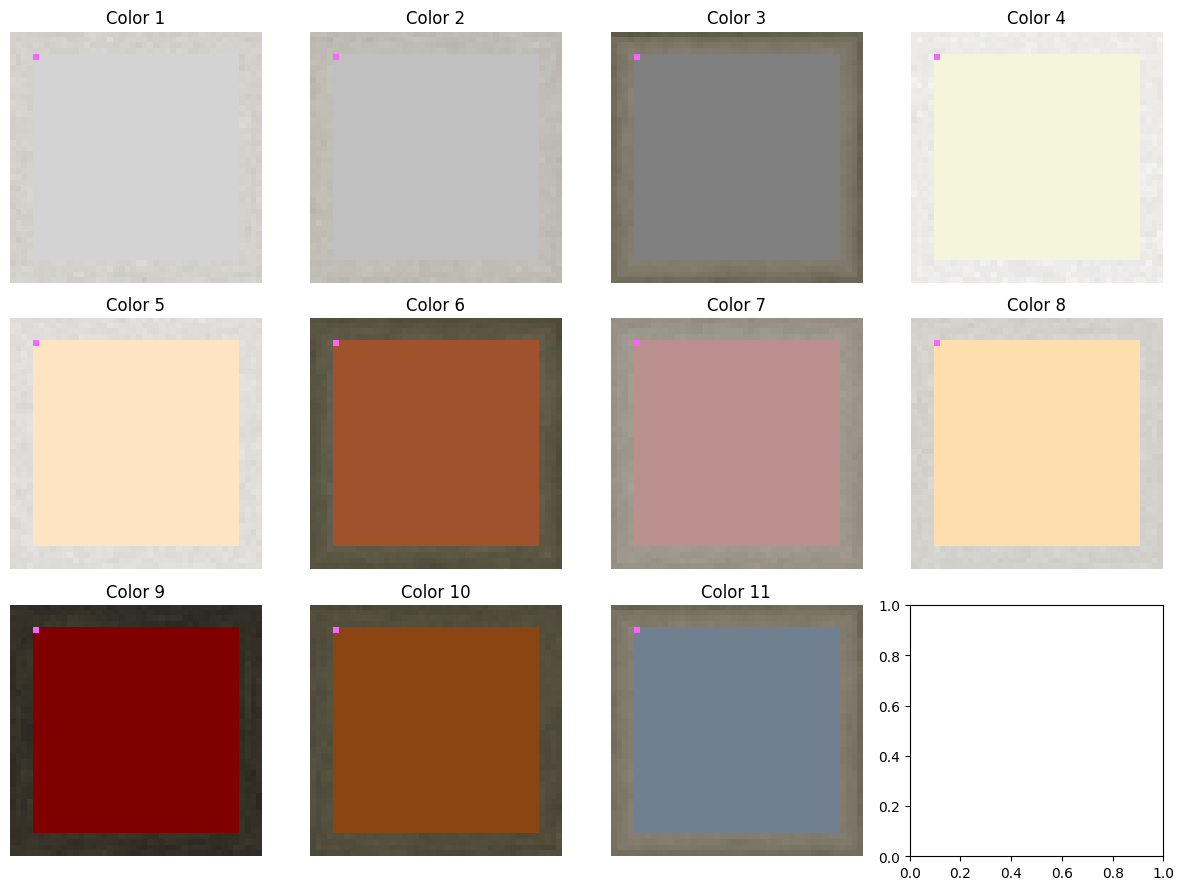

In [3]:
#Color Test

import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

def create_color_tensor(width, height, color):
    color_tensor = torch.tensor(color, dtype=torch.float32) / 255.0
    color_tensor = color_tensor.view(1, 3, 1, 1)
    # Create the tensor by repeating the color tensor across the height and width
    tensor = color_tensor.repeat(1, 1, height, width)
    return tensor

def display_color_tensors(colors):
    with torch.no_grad():

        fig, axs = plt.subplots(3, 4, figsize=(12, 9))
        axs = axs.flatten() if len(colors) > 1 else [axs]

        for idx, color in enumerate(colors):
            device = 'cuda' if torch.cuda.is_available() else 'cpu'
            print("device: ",device)
            maxSize = 44
            initSize = 36
            
            max_new_tokens = maxSize * maxSize

            color_tensor = create_color_tensor(initSize, initSize, color).to(device)

            color_tensor_indices = torch.tensor(create_spiral(initSize))
            source, _ = get_batch(color_tensor, color_tensor_indices)

            for _ in range(max_new_tokens -1 - (initSize*initSize)):
                    source_cond = source[:, -BLOCK_SIZE:]
                    
                    logits, _ = m(source_cond)
                    idx_next = logits[:, -1, :].unsqueeze(1)
                    source = torch.cat((source_cond, idx_next), dim=1) # (B, T+1)
            
            spiral_indices = torch.tensor(create_spiral(maxSize))
            positions_in_spiral = torch.argsort(spiral_indices.flatten())

            reconstructed_tensor_efficient = torch.zeros((3,maxSize*maxSize), device=device)
            source = torch.cat((source, source[:, -1, :].unsqueeze(1)), dim=1)

            source[:, initSize*initSize-1] = torch.tensor([1.0, 0.3921, 1.0], device=device)

            reconstructed_tensor_efficient[:,positions_in_spiral] = rearrange(source, '1 h c -> c h')

            # Rückumwandlung in 8x8 Format
            reconstructed_tensor_efficient = reconstructed_tensor_efficient.view(3, maxSize, maxSize)

            img = rearrange(reconstructed_tensor_efficient, 'c h w -> h w c').cpu().detach().numpy()
            
            axs[idx].imshow(img)
            axs[idx].set_axis_off()  # Hide axes
            axs[idx].set_title(f'Color {idx+1}')

        plt.tight_layout()
        plt.show()
           
    
colors = [
    [211, 211, 211], # Light Grey (Common for modern facades and interiors)
    [192, 192, 192], # Silver (Popular for both facades and stylish interiors)
    [128, 128, 128], # Grey (Standard for floors and walls, versatile)
    [245, 245, 220], # Beige (Widely used for walls, gives warmth)
    [255, 228, 196], # Bisque (Soft warm hue for interiors)
    [160, 82, 45],   # Sienna (Earthy tone, often used in tiling)
    [188, 143, 143], # Rosy Brown (Warm, welcoming color for walls)
    [255, 222, 173], # Wheat (Light, neutral color for airy spaces)
    [128, 0, 0],     # Maroon (Rich color often used in luxurious settings)
    [139, 69, 19],   # Saddle Brown (Common for wood floors or rustic facades)
    [112, 128, 144]  # Slate Gray (Popular for both exterior and interior walls)
]

display_color_tensors(colors)


device:  cuda


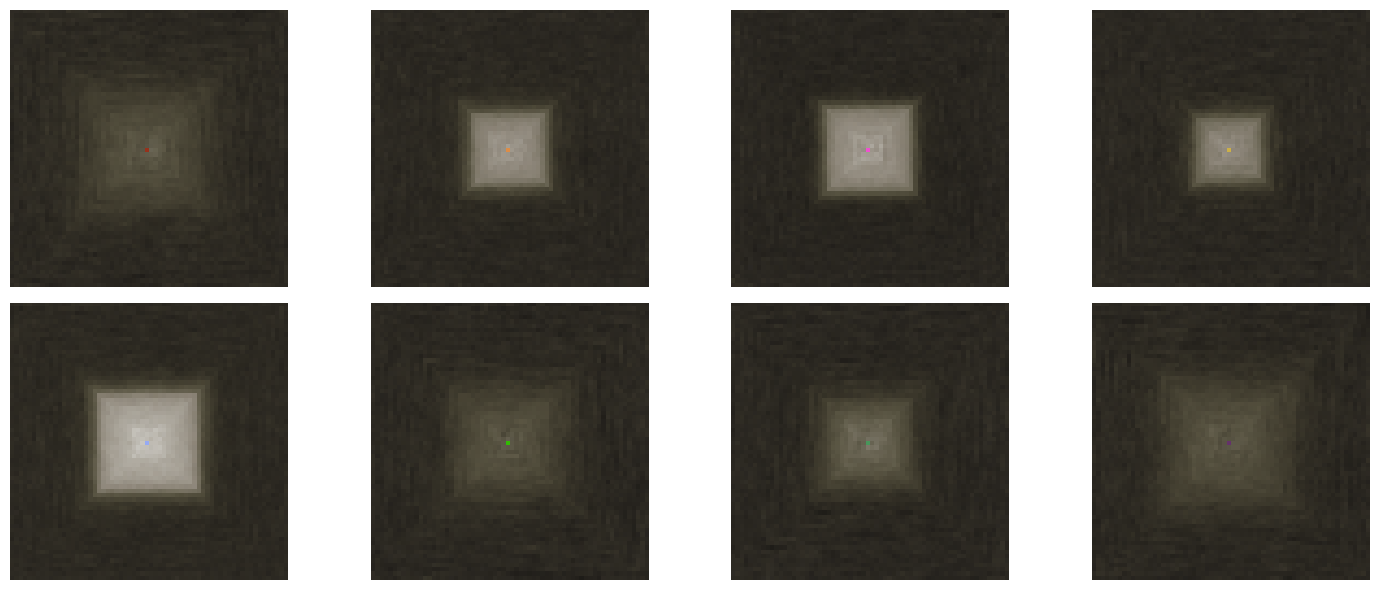

In [4]:
#Gen from singel pixel

import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

# torch.manual_seed(1337)
with torch.no_grad():
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print("device: ",device)

    # Define the image path
    # image_path = "C:\\Users\\Dennis\\Desktop\\Pro\\AITest\\gen_csgo.png"
    # Open the image file
    # img = Image.open(image_path)


    # m = torch.load(model_saveFile(0)).to(device)
    

    size = 64
    block_size = size * size - 1

    max_new_tokens = size * size


    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 6))  # Adjust as necessary
    axes = axes.flatten()

    for i in range(8):

        idx = torch.rand((1, 1, 3), device=device)
        # idx = torch.tensor([[[0.4, 0.2, 0.1]]], device=device)

        # idx = torch.tensor([[[52/255.0, 229/255.0, 235/255.0]]], device=device)

        for _ in range(max_new_tokens -1):
            idx_cond = idx[:, -block_size:]
            
            logits, _ = m(idx_cond)
            idx_next = logits[:, -1, :].unsqueeze(1)
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
            

        positions_in_spiral = torch.argsort(spiral_indices.flatten())

        reconstructed_tensor_efficient = torch.zeros((3,size*size), device=device)
        reconstructed_tensor_efficient[:,positions_in_spiral] = rearrange(idx, '1 h c -> c h')

        # Rückumwandlung in 8x8 Format
        reconstructed_tensor_efficient = reconstructed_tensor_efficient.view(3,size, size)

        image = rearrange(reconstructed_tensor_efficient, 'c h w -> h w c').cpu().detach().numpy()
        axes[i].imshow(image)
        axes[i].axis('off')

plt.tight_layout()
plt.show()

device:  cuda


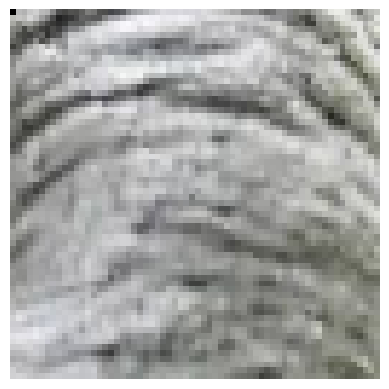

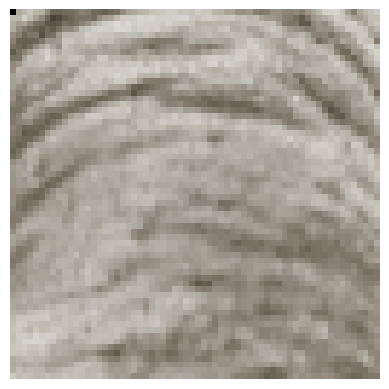

In [13]:
#Gen Ape check model Ouput

import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

# torch.manual_seed(1337)
with torch.no_grad():
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print("device: ",device)


    size = 64
    block_size = size * size - 1

    max_new_tokens = size * size

    image_path = r"..\..\..\resources\genImges\genApeTestPic.jpg"
    img = Image.open(image_path)

    transform = transforms.Compose([
        transforms.RandomCrop((size, size)),
        transforms.ToTensor(),
    ])

    img = transform(img)
    img_tensor = img.to(device)
    img_tensor = img_tensor[:3,:,:].unsqueeze(dim=0) # Remove alpha channel

    x, y = get_batch(img_tensor)
  
    gen, _ = m(x)
 

    positions_in_spiral_y = torch.argsort(spiral_indices.flatten())

    reconstructed_tensor_efficient_y = torch.zeros((3,size*size), device=device)

    y = torch.cat((y, torch.zeros(1,1,3, device=device)), dim=1)

    reconstructed_tensor_efficient_y[:,positions_in_spiral] = rearrange(y, '1 h c -> c h')

    # Rückumwandlung in 8x8 Format
    reconstructed_tensor_efficient_y = reconstructed_tensor_efficient_y.view(3,size, size)

    image_y = rearrange(reconstructed_tensor_efficient_y, 'c h w -> h w c').cpu().detach().numpy()
    plt.imshow(image_y)
    plt.axis('off')
    plt.show()

#----------------------------------------------
    positions_in_spiral = torch.argsort(spiral_indices.flatten())

    reconstructed_tensor_efficient = torch.zeros((3,size*size), device=device)

    idx = torch.cat((gen, torch.zeros(1,1,3, device=device)), dim=1)

    reconstructed_tensor_efficient[:,positions_in_spiral] = rearrange(idx, '1 h c -> c h')

    # Rückumwandlung in 8x8 Format
    reconstructed_tensor_efficient = reconstructed_tensor_efficient.view(3,size, size)

    image = rearrange(reconstructed_tensor_efficient, 'c h w -> h w c').cpu().detach().numpy()
    plt.imshow(image)
    plt.axis('off')
    plt.show()


device:  cuda


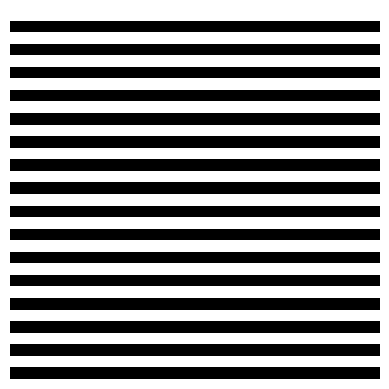

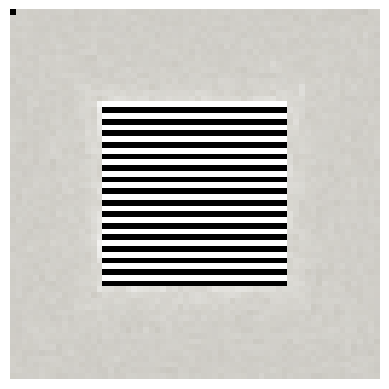

In [15]:
#Gen zebra pattern check model Ouput

import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

# torch.manual_seed(1337)
with torch.no_grad():
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print("device: ",device)


    size = 64
    block_size = size * size - 1

    max_new_tokens = size * size


    zebra_tensor_size = 32

    zebra_tensor = torch.zeros((1, zebra_tensor_size, zebra_tensor_size, 3), device=device)

    for row in range(zebra_tensor.shape[2]):
        if row % 2 == 0:
            zebra_tensor[:, row, :] = torch.tensor([255, 255, 255], device=device) # White
        else:
            zebra_tensor[:, row, :] = torch.tensor([0, 0, 0], device=device) # Black


    zebra_tensor = rearrange(zebra_tensor, ' 1 h w c -> 1 c h w')

    # Displaying the tensor as an image
    plt.imshow(rearrange(zebra_tensor, '1 c h w -> h w c').cpu().detach().numpy().astype('int'))
    plt.axis('off')  # Turn off axis numbers
    plt.show()

    zebra_tensor_spiral_indices = torch.tensor(create_spiral(zebra_tensor_size))


    zebra_tensor = zebra_tensor / 255.0
    x, y = get_batch(zebra_tensor, zebra_tensor_spiral_indices)

    plt.imshow(rearrange(x * 255, '1 w c -> 1 w c').cpu().detach().numpy().astype('int'))
    plt.axis('off')  # Turn off axis numbers
    plt.show()


    idx = x

    for _ in range(max_new_tokens -1 - (zebra_tensor_size*zebra_tensor_size)):
        idx_cond = idx[:, -block_size:]
        
        logits, _ = m(idx_cond)
        idx_next = logits[:, -1, :].unsqueeze(1)
        idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
            


    positions_in_spiral = torch.argsort(spiral_indices.flatten())

    reconstructed_tensor_efficient = torch.zeros((3,size*size), device=device)

    idx = torch.cat((idx, torch.zeros(1,1,3, device=device)), dim=1)
    reconstructed_tensor_efficient[:,positions_in_spiral] = rearrange(idx, '1 h c -> c h')

    # Rückumwandlung in 8x8 Format
    reconstructed_tensor_efficient = reconstructed_tensor_efficient.view(3,size, size)


    plt.imshow(rearrange(reconstructed_tensor_efficient, 'c h w -> h w c').cpu().detach().numpy())
    plt.axis('off')
    plt.show()



device:  cuda


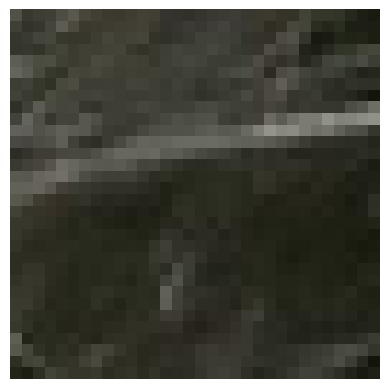

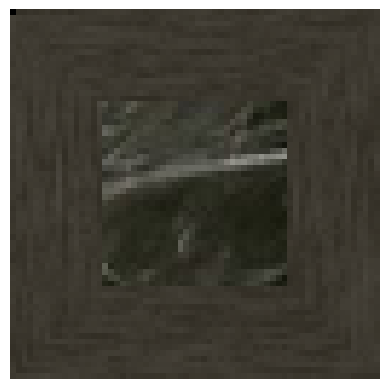

In [16]:
#Gen zebra pattern check model Ouput

import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

# torch.manual_seed(1337)
with torch.no_grad():
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print("device: ",device)


    size = 64
    block_size = size * size - 1

    max_new_tokens = size * size


    img_tensor_size = 32

    image_path = "../../../resources/genImges/genApeTestPic.jpg"
    img = Image.open(image_path)

    transform = transforms.Compose([
        transforms.RandomCrop((img_tensor_size, img_tensor_size)),
        transforms.ToTensor(),
    ])

    img = transform(img)
    img_tensor = img.to(device)
    img_tensor = img_tensor[:3,:,:].unsqueeze(dim=0) # Remove alpha channel

    # Displaying the tensor as an image
    plt.imshow(rearrange(img_tensor *255, '1 c h w -> h w c').cpu().detach().numpy().astype('int'))
    plt.axis('off')  # Turn off axis numbers
    plt.show()

    # m = torch.load(model_saveFile(0)).to(device)
    m = torch.load(r"C:\Users\Dennis\Desktop\model_5.0.0.2\model5.0.0.2_bigData_FloorEP0.pth").to(device)

    img_tensor_spiral_indices = torch.tensor(create_spiral(img_tensor_size))

    x, y = get_batch(img_tensor, img_tensor_spiral_indices)

    plt.imshow(rearrange(x * 255, '1 w c -> 1 w c').cpu().detach().numpy().astype('int'))
    plt.axis('off')  # Turn off axis numbers
    plt.show()


    idx = x

    for _ in range(max_new_tokens -1 - (img_tensor_size*img_tensor_size)):
        idx_cond = idx[:, -block_size:]
        
        logits, _ = m(idx_cond)
        idx_next = logits[:, -1, :].unsqueeze(1)
        idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
            


    positions_in_spiral = torch.argsort(spiral_indices.flatten())

    reconstructed_tensor_efficient = torch.zeros((3,size*size), device=device)

    idx = torch.cat((idx, torch.zeros(1,1,3, device=device)), dim=1)
    reconstructed_tensor_efficient[:,positions_in_spiral] = rearrange(idx, '1 h c -> c h')

    # Rückumwandlung in 8x8 Format
    reconstructed_tensor_efficient = reconstructed_tensor_efficient.view(3,size, size)


    plt.imshow(rearrange(reconstructed_tensor_efficient, 'c h w -> h w c').cpu().detach().numpy())
    plt.axis('off')
    plt.show()



device:  cuda


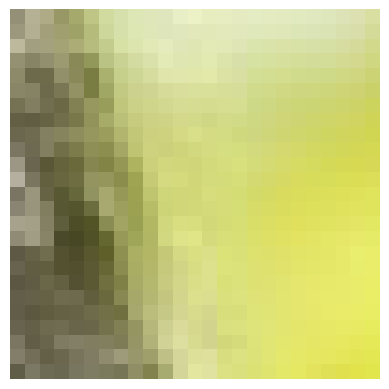

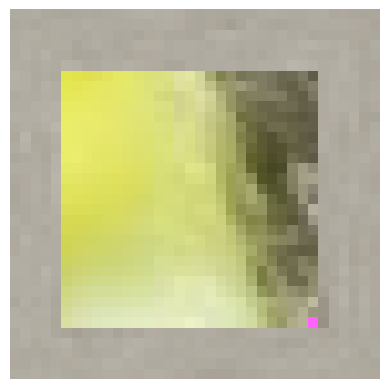

In [4]:
#Gen zebra pattern check model Ouput

import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

# torch.manual_seed(1337)
with torch.no_grad():
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print("device: ",device)


    size = 36
    block_size = size * size - 1

    max_new_tokens = size * size


    img_tensor_size = 25

    image_path = "../../../resources/genImges/genApeTestPic_cut.jpg"
    img = Image.open(image_path)

    transform = transforms.Compose([
        transforms.RandomCrop((img_tensor_size, img_tensor_size)),
        transforms.ToTensor(),
    ])

    img = transform(img)
    img_tensor = img.to(device)
    img_tensor = img_tensor[:3,:,:].unsqueeze(dim=0) # Remove alpha channel

    # Displaying the tensor as an image
    plt.imshow(rearrange(img_tensor *255, '1 c h w -> h w c').cpu().detach().numpy().astype('int'))
    plt.axis('off')  # Turn off axis numbers
    plt.show()

    img_tensor_spiral_indices = torch.tensor(create_spiral(img_tensor_size))

    x, y = get_batch(img_tensor, img_tensor_spiral_indices)

    plt.imshow(rearrange(x * 255, '1 w c -> 1 w c').cpu().detach().numpy().astype('int'))
    plt.axis('off')  # Turn off axis numbers
    plt.show()


    idx = x

    for _ in range(max_new_tokens -1 - (img_tensor_size*img_tensor_size)):
        idx_cond = idx[:, -block_size:]
        
        logits, _ = m(idx_cond)
        idx_next = logits[:, -1, :].unsqueeze(1)
        idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
            

    spiral_indices = torch.tensor(create_spiral(size))
    positions_in_spiral = torch.argsort(spiral_indices.flatten())

    reconstructed_tensor_efficient = torch.zeros((3,size*size), device=device)

    idx = torch.cat((idx, idx[:, -1, :].unsqueeze(1)), dim=1)
    idx[:, img_tensor_size*img_tensor_size-1] = torch.tensor([1.0, 0.3921, 1.0], device=device)

    reconstructed_tensor_efficient[:,positions_in_spiral] = rearrange(idx, '1 h c -> c h')

    # Rückumwandlung in 8x8 Format
    reconstructed_tensor_efficient = reconstructed_tensor_efficient.view(3,size, size)


    plt.imshow(rearrange(reconstructed_tensor_efficient, 'c h w -> h w c').cpu().detach().numpy())
    plt.axis('off')
    plt.show()

